<a href="https://colab.research.google.com/github/AftabUdaipurwala/MLProjects/blob/main/Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problem Statement

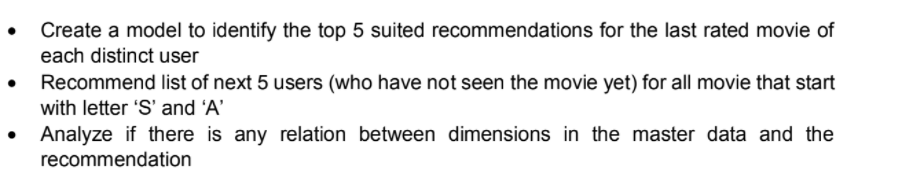

# Library Section

In [115]:
!pip install scikit-surprise

In [116]:
# importing whatever libraries are necessary to run the program
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import math
from sklearn.cluster import DBSCAN
import matplotlib
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.decomposition import PCA
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

# Data Import

In [117]:
# Mounting the drive for loading the data
drive.mount('/content/drive')
!ls '/content/drive/MyDrive/Data Science Learning Path/Case Studies/ACT'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'ACT India D&A GCC_Data Science Manager_Case.pdf'  'movies master.csv'
 links.csv					    ratings.csv
 movies.csv					    tags.csv


In [118]:
# reading x and y variables in the data set
links = pd.read_csv('/content/drive/MyDrive/Data Science Learning Path/Case Studies/ACT/links.csv')
movies = pd.read_csv('/content/drive/MyDrive/Data Science Learning Path/Case Studies/ACT/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/Data Science Learning Path/Case Studies/ACT/ratings.csv')
master = pd.read_csv('/content/drive/MyDrive/Data Science Learning Path/Case Studies/ACT/movies master.csv')
tags = pd.read_csv('/content/drive/MyDrive/Data Science Learning Path/Case Studies/ACT/tags.csv')

In [119]:
links.head(2)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0


In [120]:
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [121]:
ratings.head(2)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247


In [122]:
tags.head(2)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996


In [123]:
master.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0


# Data set Relation 

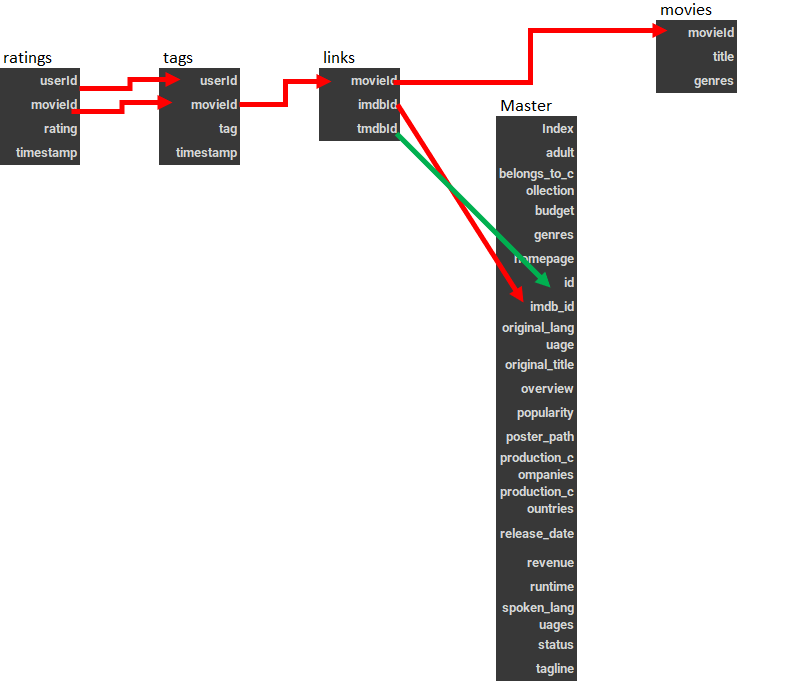

# Exploratory Data Analysis

## Ratings data

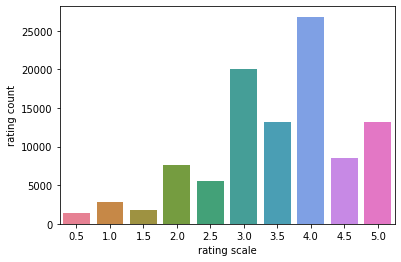

In [124]:
# Checking what is the maximum ratings that films are likely to get
df= pd.DataFrame(ratings.rating.value_counts()).sort_index(ascending=False)
df = df.reset_index(level=0)
df= df.rename({'index': 'rating scale', 'rating': 'rating count'}, axis=1) 
sns.barplot(x=df['rating scale'], y=df['rating count'], data= df, palette='husl')

In [125]:
# counting users unique ids
usercount= pd.DataFrame(ratings.userId.value_counts())
usercount = usercount.reset_index(level=0)
usercount= usercount.rename({'index': 'user_id', 'userId': 'counts'}, axis=1)
usercount.head(5)
print(f"\nUnique users count is :",len(usercount.user_id.unique()),f"\nTotal Rating count is :",len(ratings),f"\nPercentage of unique users to total dataset :",round(len(usercount.user_id.unique())/len(ratings)*100,2),"%")


Unique users count is : 610 
Total Rating count is : 100836 
Percentage of unique users to total dataset : 0.6 %


In [126]:
# counting movies unique ids
moviecount= pd.DataFrame(ratings.movieId.value_counts())
moviecount = moviecount.reset_index(level=0)
moviecount= moviecount.rename({'index': 'movie_id', 'movieId': 'counts'}, axis=1)
moviecount.head(5)
print(f"\nUnique movies count is :",len(moviecount.movie_id.unique()),f"\nTotal Rating count is :",len(ratings),f"\nPercentage of unique movies to total dataset :",round(len(moviecount.movie_id.unique())/len(ratings)*100,2),"%")


Unique movies count is : 9724 
Total Rating count is : 100836 
Percentage of unique movies to total dataset : 9.64 %


In [127]:
# checking missing values in ratings data 
ratings.isna().sum() # thus no missing value

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [128]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'],unit='s')
ratings['Dates'] = ratings['timestamp'].dt.to_period('Y')
ratings.head(2)

,userId,movieId,rating,timestamp,Dates
0,1,1,4.0,2000-07-30 18:45:03,2000
1,1,3,4.0,2000-07-30 18:20:47,2000


In [129]:
ratings.Dates

0         2000
1         2000
2         2000
3         2000
4         2000
          ... 
100831    2017
100832    2017
100833    2017
100834    2017
100835    2017
Name: Dates, Length: 100836, dtype: period[A-DEC]

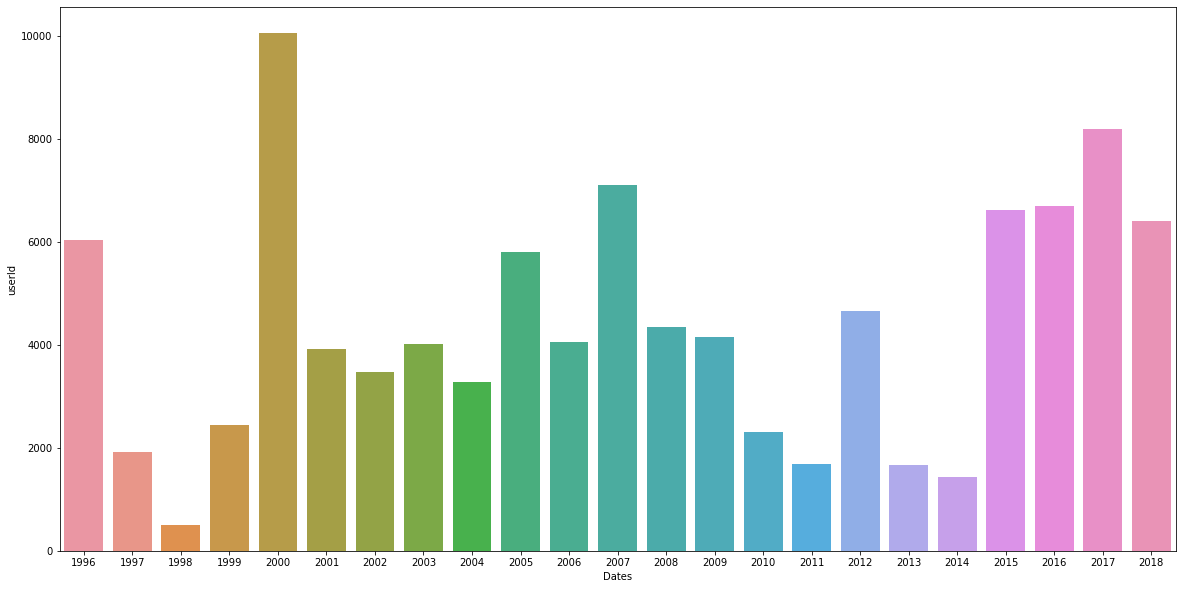

In [130]:
plt.figure(figsize=(20,10))
g=ratings.groupby('Dates')
g=g.count()
g = g.reset_index(level=0)
h= sns.barplot(x='Dates', y='userId', data =g)
# thus we can say the there is no particular pattern in year on year increase or decrease, but in last 3 years its showing consitently 6000 ratings given

In [131]:
g.tail(5)

,Dates,userId,movieId,rating,timestamp
18,2014,1439,1439,1439,1439
19,2015,6616,6616,6616,6616
20,2016,6703,6703,6703,6703
21,2017,8198,8198,8198,8198
22,2018,6418,6418,6418,6418


In [132]:
ratingcountbyuser = (ratings['userId'].groupby(ratings['movieId']).count()
                     .astype(int).reset_index(name='Counts'))
ratingcountbyuser

,movieId,Counts
0,1,215
1,2,110
2,3,52
3,4,7
4,5,49
...,...,...
9719,193581,1
9720,193583,1
9721,193585,1
9722,193587,1


## Movies

In [133]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [134]:
# movies.genres.unique() #commneted because list was too huge

In [135]:
movie_genre=["movieId",	"title",	"genres","Adventure","Animation","Children","Comedy","Fantasy","Romance","Drama","Action","Crime","Thriller","Horror","Mystery","Sci-Fi","War","Musical","Documentary","IMAX","Western","Film-Noir","(no genres listed)"]
movies = movies.reindex(columns=movie_genre)
movies['Adventure']=movies.genres.str.contains('Adventure')
movies['Animation']=movies.genres.str.contains('Animation')
movies['Children']=movies.genres.str.contains('Children')
movies['Comedy']=movies.genres.str.contains('Comedy')
movies['Fantasy']=movies.genres.str.contains('Fantasy')
movies['Adventure']=movies.genres.str.contains('Adventure')
movies['Romance']=movies.genres.str.contains('Romance')
movies['Drama']=movies.genres.str.contains('Drama')
movies['Action']=movies.genres.str.contains('Action')
movies['Crime']=movies.genres.str.contains('Crime')
movies['Thriller']=movies.genres.str.contains('Thriller')
movies['Horror']=movies.genres.str.contains('Horror')
movies['Mystery']=movies.genres.str.contains('Mystery')
movies['Sci-Fi']=movies.genres.str.contains('Sci-Fi')
movies['War']=movies.genres.str.contains('War')
movies['Musical']=movies.genres.str.contains('Musical')
movies['Documentary']=movies.genres.str.contains('Documentary')
movies['IMAX']=movies.genres.str.contains('IMAX')
movies['Western']=movies.genres.str.contains('Western')
movies['Film-Noir']=movies.genres.str.contains('Film-Noir')
movies['(no genres listed)']=movies.genres.str.contains('(no genres listed)')


In [136]:
movies.replace({False: 0, True: 1}, inplace=True)
movies

,movieId,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),Drama,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


[Text(0, 0, 'Adventure'),
 Text(0, 0, 'Animation'),
 Text(0, 0, 'Children'),
 Text(0, 0, 'Comedy'),
 Text(0, 0, 'Fantasy'),
 Text(0, 0, 'Romance'),
 Text(0, 0, 'Drama'),
 Text(0, 0, 'Action'),
 Text(0, 0, 'Crime'),
 Text(0, 0, 'Thriller'),
 Text(0, 0, 'Horror'),
 Text(0, 0, 'Mystery'),
 Text(0, 0, 'Sci-Fi'),
 Text(0, 0, 'War'),
 Text(0, 0, 'Musical'),
 Text(0, 0, 'Documentary'),
 Text(0, 0, 'IMAX'),
 Text(0, 0, 'Western'),
 Text(0, 0, 'Film-Noir'),
 Text(0, 0, '(no genres listed)')]

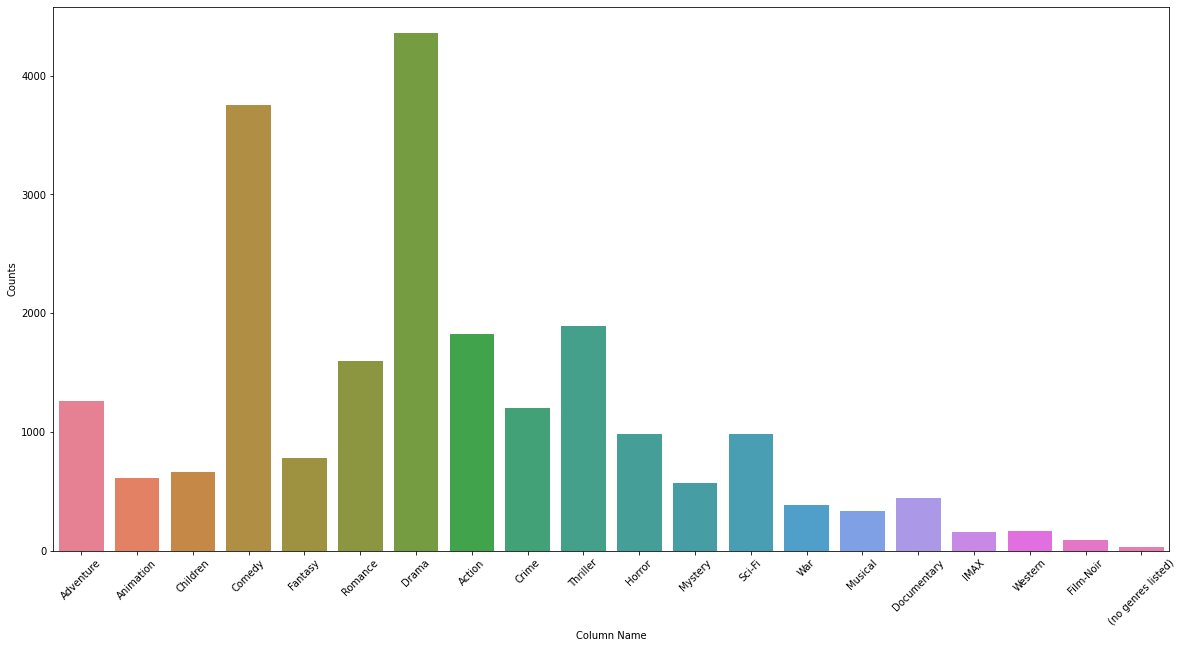

In [137]:
unique_genre=["Adventure","Animation","Children","Comedy","Fantasy","Romance","Drama","Action","Crime","Thriller","Horror","Mystery","Sci-Fi","War","Musical","Documentary","IMAX","Western","Film-Noir","(no genres listed)"]
movies_graph= pd.DataFrame(movies.sum())
movies_graph = movies_graph.reset_index(level=0)
movies_graph= movies_graph.rename({'index': 'Column Name', 0: 'Counts'}, axis=1) 
movies_graph = movies_graph.loc[3:,]
movies_graph
plt.figure(figsize=(20,10))
g=sns.barplot(x=movies_graph['Column Name'], y=movies_graph['Counts'], data= movies_graph, palette='husl')
g.set_xticklabels(labels=unique_genre,rotation=45)

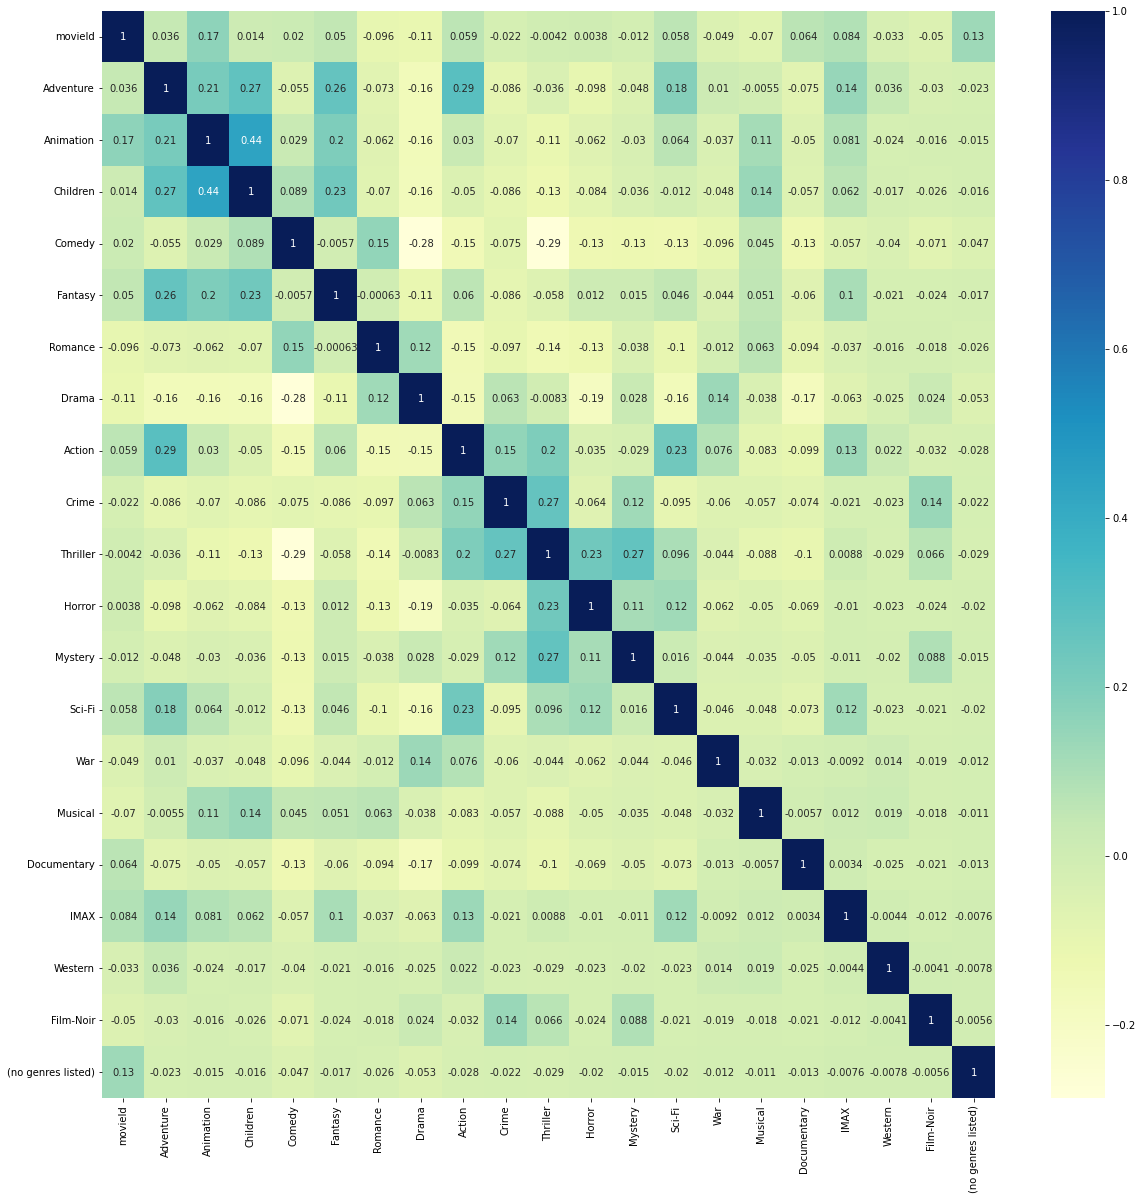

In [138]:
# plotting correlation heatmap
plt.figure(figsize=(20,20))
dataplot = sns.heatmap(movies.corr(), cmap="YlGnBu", annot=True)
plt.show()
# obviously it looks common genres type have better correlation though numbers are small but does imply significance, eg Animation & Children, Adventure and War,Animation etc is high


In [139]:
movies= movies.merge(ratingcountbyuser, on='movieId', how='left')
movies.sort_values(by='Counts',ascending=False)

,movieId,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed),Counts
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War,0,0,0,1,0,1,1,...,0,0,1,0,0,0,0,0,0,329.0
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,317.0
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,307.0
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,279.0
1939,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,278.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5749,30892,In the Realms of the Unreal (2004),Animation|Documentary,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,NaN
5824,32160,Twentieth Century (1934),Comedy,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
5837,32371,Call Northside 777 (1948),Crime|Drama|Film-Noir,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,NaN
5957,34482,"Browning Version, The (1951)",Drama,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN


In [140]:
movies[movies.Counts.isnull()] # these 18 movies have not been rated hence they should be kept aside for model training purpose right now

,movieId,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed),Counts
816,1076,"Innocents, The (1961)",Drama|Horror|Thriller,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN
2211,2939,Niagara (1953),Drama|Thriller,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN
2499,3338,For All Mankind (1989),Documentary,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,NaN
2587,3456,"Color of Paradise, The (Rang-e khoda) (1999)",Drama,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN
3118,4194,I Know Where I'm Going! (1945),Drama|Romance|War,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,NaN
4037,5721,"Chosen, The (1981)",Drama,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN
4506,6668,"Road Home, The (Wo de fu qin mu qin) (1999)",Drama|Romance,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
4598,6849,Scrooge (1970),Drama|Fantasy|Musical,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,NaN
4704,7020,Proof (1991),Comedy|Drama|Romance,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
5020,7792,"Parallax View, The (1974)",Thriller,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [141]:
movies_rated= movies[movies.Counts.notnull()]
movies_rated.shape

(9724, 24)

In [142]:
# searching movies starting with S or A
movies_rated_SA= movies_rated.loc[(movies_rated.title.str.startswith('S')|movies_rated.title.str.startswith('A'))]
movies_rated_SA.shape

(1486, 24)

In [143]:
movies_rated_SA.sort_values(by='Counts', ascending = False).head(5)

,movieId,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed),Counts
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,317.0
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,279.0
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,251.0
461,527,Schindler's List (1993),Drama|War,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,220.0
898,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,211.0


In [144]:
unique_genre=["Adventure","Animation","Children","Comedy","Fantasy","Romance","Drama","Action","Crime","Thriller","Horror","Mystery","Sci-Fi","War","Musical","Documentary","IMAX","Western","Film-Noir","(no genres listed)"]
movies_graph= pd.DataFrame(movies_rated_SA.sum())
movies_graph = movies_graph.reset_index(level=0)
movies_graph= movies_graph.rename({'index': 'Column Name', 0: 'Counts'}, axis=1) 
movies_graph = movies_graph.loc[3:22,]
movies_graph.sort_values(by='Counts', ascending=False)  

,Column Name,Counts
9,Drama,663
6,Comedy,566
12,Thriller,290
10,Action,273
8,Romance,254
3,Adventure,213
15,Sci-Fi,188
11,Crime,161
13,Horror,147
5,Children,131


In [145]:
print("In S & A Movies, there are --> ",movies_rated_SA.shape[0],"movies and they are rated by -->", movies_graph.Counts.sum(),"users")

In S & A Movies, there are -->  1486 movies and they are rated by --> 3466 users


## Tags data

In [146]:
tags.head(5)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


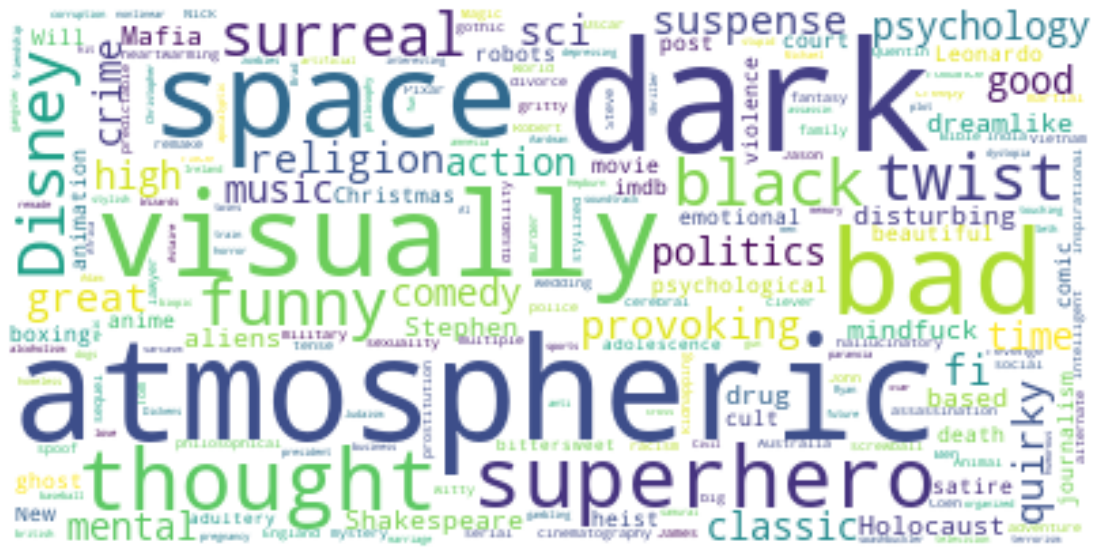

In [147]:
text = " ".join(cat.split()[0] for cat in tags.tag)
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
plt.figure(figsize=(20,10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# word cloud clearly shows we can use the tags for finding the correlated movies 

In [148]:
# counting users unique ids
usercount= pd.DataFrame(tags.userId.value_counts())
usercount = usercount.reset_index(level=0)
usercount= usercount.rename({'index': 'user_id', 'userId': 'counts'}, axis=1)
print(f"\nUnique users count is :",len(usercount.user_id.unique()),f"\nTotal movie count is :",len(tags.movieId.unique()))


Unique users count is : 58 
Total movie count is : 1572


In [149]:
tags.shape[0], usercount.shape[0] # thus the unique user id in the tags data is too less and hence it doesnt make much sense to use this data set right now
#may be we will comeback to it later if needed 

(3683, 58)

## Master Data

In [150]:
master.rename(columns={'id': 'movieId', 'imdb_id': 'imdbId'}, inplace=True)

In [151]:
master=master[master.title.notnull()]

In [152]:
master.head(3)

,adult,belongs_to_collection,budget,genres,homepage,movieId,imdbId,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [153]:
len(master.movieId.unique())
# thus total movies that are rated are 9724 but in master we have close to 45k movies which means we will be using the master data for 9.7k movies as of now

45430

In [154]:
master.isnull().sum().sort_values(ascending=False)

belongs_to_collection    40970
homepage                 37682
tagline                  25048
overview                   954
poster_path                383
runtime                    257
release_date                84
status                      81
imdbId                      17
original_language           11
adult                        0
vote_average                 0
video                        0
title                        0
spoken_languages             0
production_companies         0
revenue                      0
production_countries         0
popularity                   0
original_title               0
movieId                      0
genres                       0
budget                       0
vote_count                   0
dtype: int64

In [155]:
master.dtypes
# Since revenue, runtime, vote average and vote counts are float hence they can be imputed, but only except runtime can be imputed by mean as if you see for run time its 263 missing value

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
movieId                   object
imdbId                    object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

(<matplotlib.axes._subplots.AxesSubplot at 0x7f2081c10510>, 95.0)

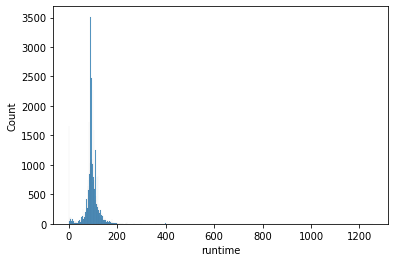

In [156]:
sns.histplot(x=master.runtime, palette='husl'), master.runtime.quantile(.5) # lets impute by median value

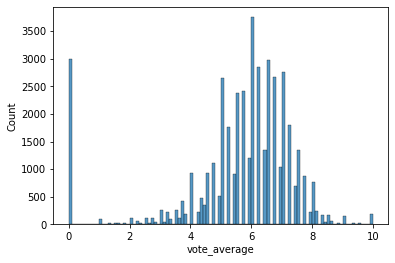

In [157]:
sns.histplot(x=master.vote_average,palette='husl') # thus imputing by mean is safe

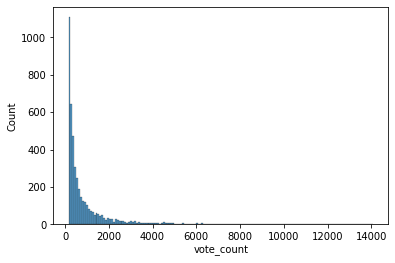

In [158]:
sns.histplot(x=master.vote_count[master.vote_count>master.vote_count.quantile(0.90)],palette='husl') # hence imputation can be done on basis of 25th percentile value to be on safe side

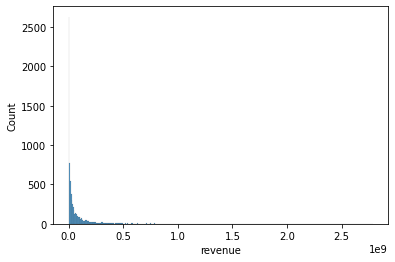

In [159]:
sns.histplot(x=master.revenue[master.revenue>master.revenue.quantile(0.75)],palette='husl')  # hence replace missing values by 25th percentile only

In [160]:
master.revenue=master.revenue.fillna(0) # since all values below 75th percentile are 0
master.vote_count=master.vote_count.fillna(3) # Since 25th perecentile is at 160
master.vote_average=master.vote_average.fillna(master.vote_average.mean())
master.runtime=master.runtime.fillna(master.runtime.median())
master.isnull().sum().sort_values(ascending=False) # rest missing values are text and hence it can be ignored for now, if in next steps we can impute the text too

belongs_to_collection    40970
homepage                 37682
tagline                  25048
overview                   954
poster_path                383
release_date                84
status                      81
imdbId                      17
original_language           11
adult                        0
runtime                      0
vote_average                 0
video                        0
title                        0
spoken_languages             0
production_companies         0
revenue                      0
production_countries         0
popularity                   0
original_title               0
movieId                      0
genres                       0
budget                       0
vote_count                   0
dtype: int64

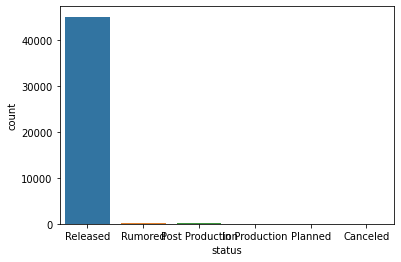

In [161]:
%matplotlib inline
sns.countplot(data=master, x='status')

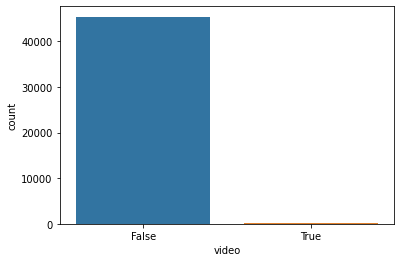

In [162]:
%matplotlib inline
sns.countplot(data=master, x='video')

# Data Preparation

In [163]:
ratings.head(3)

,userId,movieId,rating,timestamp,Dates
0,1,1,4.0,2000-07-30 18:45:03,2000
1,1,3,4.0,2000-07-30 18:20:47,2000
2,1,6,4.0,2000-07-30 18:37:04,2000


In [164]:
movies.head(3)

,movieId,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed),Counts
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,215.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,110.0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,52.0


In [165]:
ratings_movies = ratings.merge(movies, on='movieId', how='left')
ratings_movies.head(3)

,userId,movieId,rating,timestamp,Dates,title,genres,Adventure,Animation,Children,...,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed),Counts
0,1,1,4.0,2000-07-30 18:45:03,2000,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,1,...,0,0,0,0,0,0,0,0,0,215.0
1,1,3,4.0,2000-07-30 18:20:47,2000,Grumpier Old Men (1995),Comedy|Romance,0,0,0,...,0,0,0,0,0,0,0,0,0,52.0
2,1,6,4.0,2000-07-30 18:37:04,2000,Heat (1995),Action|Crime|Thriller,0,0,0,...,0,0,0,0,0,0,0,0,0,102.0


In [166]:
# removing the non numeric values from movieID column in the master data as i observed couple of dates , else if not removed it will cause issue in merging master table
master1= master[pd.to_numeric(master['movieId'], errors='coerce').notnull()]
master1.shape[0]- master.shape[0] # thus u can see 3 movies are removed

0

In [167]:
master1.head(2)

,adult,belongs_to_collection,budget,genres,homepage,movieId,imdbId,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [168]:
master1.rename({'movieId': 'tmdbId'}, axis=1, inplace=True)
master1.head(2)

,adult,belongs_to_collection,budget,genres,homepage,tmdbId,imdbId,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [169]:
master1['tmdbId']= master1['tmdbId'].astype(float, errors = 'raise')

In [170]:
links.head()
links_master= links.merge(master1,on=['tmdbId'], how='left')
links_master.head(2)

,movieId,imdbId_x,tmdbId,adult,belongs_to_collection,budget,genres,homepage,imdbId_y,original_language,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,1,114709,862.0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,tt0114709,en,...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,2,113497,8844.0,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,tt0113497,en,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [171]:
# merging links,master movies and ratings data to be called as lmmr
lmmr= ratings_movies.merge(links_master,on='movieId', how='left')
lmmr.head(5)

,userId,movieId,rating,timestamp,Dates,title_x,genres_x,Adventure,Animation,Children,...,release_date,revenue,runtime,spoken_languages,status,tagline,title_y,video,vote_average,vote_count
0,1,1,4.0,2000-07-30 18:45:03,2000,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,1,...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,1,3,4.0,2000-07-30 18:20:47,2000,Grumpier Old Men (1995),Comedy|Romance,0,0,0,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
2,1,6,4.0,2000-07-30 18:37:04,2000,Heat (1995),Action|Crime|Thriller,0,0,0,...,1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
3,1,47,5.0,2000-07-30 19:03:35,2000,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,0,0,0,...,1995-09-22,327311859.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Seven deadly sins. Seven ways to die.,Se7en,False,8.1,5915.0
4,1,50,5.0,2000-07-30 18:48:51,2000,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,0,0,0,...,1995-07-19,23341568.0,106.0,"[{'iso_639_1': 'es', 'name': 'Español'}, {'iso...",Released,Five Criminals. One Line Up. No Coincidence.,The Usual Suspects,False,8.1,3334.0


In [172]:
lmmr.columns, lmmr.shape

(Index(['userId', 'movieId', 'rating', 'timestamp', 'Dates', 'title_x',
        'genres_x', 'Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
        'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery',
        'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX', 'Western',
        'Film-Noir', '(no genres listed)', 'Counts', 'imdbId_x', 'tmdbId',
        'adult', 'belongs_to_collection', 'budget', 'genres_y', 'homepage',
        'imdbId_y', 'original_language', 'original_title', 'overview',
        'popularity', 'poster_path', 'production_companies',
        'production_countries', 'release_date', 'revenue', 'runtime',
        'spoken_languages', 'status', 'tagline', 'title_y', 'video',
        'vote_average', 'vote_count'],
       dtype='object'), (100874, 53))

In [173]:
for col in lmmr.columns:
    if len(lmmr[col].unique()) == 1:
        lmmr.drop(col,inplace=True,axis=1)

In [174]:
lmmr.shape # hence all columns has atleast 2 unique values

(100874, 53)

# Problem Statement 1 : Recommend Unseen movie to the user

## Surprise Package in Python for comparing multiple models

In [175]:
df= ratings
df.drop(['timestamp','Dates'], axis=1, inplace=True)
df.columns = ['userID', 'item', 'rating']
df.head(4)
df

,userID,item,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [176]:
# Dimensionality Reduction
min_ratings = 5
filter_items = df['item'].value_counts() > min_ratings
filter_items = filter_items[filter_items].index.tolist()

min_user_ratings = 5
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['item'].isin(filter_items)) & (df['userID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(100836, 3)
The new data frame shape:	(88364, 3)


In [177]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_new[['userID', 'item', 'rating']], reader)

In [ ]:
benchmark = []
# Iterate over all algorithms

algorithms = [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]

print ("Attempting: ", str(algorithms), '\n\n\n')

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    # results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    print("Done: " ,str(algorithm), "\n\n")

print ('\n\tDONE\n')

Attempting:  [<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7f2080d63610>, <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x7f2080d63a10>, <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x7f2080d63f90>, <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7f2080d63dd0>, <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7f2080d63ad0>, <surprise.prediction_algorithms.knns.KNNBaseline object at 0x7f2080d63f50>, <surprise.prediction_algorithms.knns.KNNBasic object at 0x7f2080d63e10>, <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x7f207ff8e050>, <surprise.prediction_algorithms.knns.KNNWithZScore object at 0x7f207ff8e090>, <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x7f207ff8e0d0>, <surprise.prediction_algorithms.co_clustering.CoClustering object at 0x7f207ff8e110>] 



Starting:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7f2080d

In [ ]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

In [ ]:
 param_grid = {
     "n_epochs": [5, 10, 15, 20, 30, 40, 50, 100],
     "lr_all": [0.001, 0.002, 0.005],
     "reg_all": [0.02, 0.08, 0.4, 0.6]
 }

gs = GridSearchCV(KNNBaseline, param_grid, measures=["rmse", "mae"], refit=True, cv=5)

gs.fit(data)

training_parameters = gs.best_params["rmse"]

print("BEST RMSE: \t", gs.best_score["rmse"])
print("BEST MAE: \t", gs.best_score["mae"])
print("BEST params: \t", gs.best_params["rmse"])

In [ ]:
from datetime import datetime
print(training_parameters)
reader = Reader(rating_scale=(0, 5))

print("\n\n\t\t STARTING\n\n")
start = datetime.now()

print("> Loading data...")
data = Dataset.load_from_df(df_new[['userID', 'item', 'rating']], reader)
print("> OK")

print("> Creating trainset...")
trainset = data.build_full_trainset()
print("> OK")


startTraining = datetime.now()
print("> Training...")

algo = KNNBaseline(n_epochs = training_parameters['n_epochs'], lr_all = training_parameters['lr_all'], reg_all = training_parameters['reg_all'])

algo.fit(trainset)

endTraining = datetime.now()
print("> OK \t\t It Took: ", (endTraining-startTraining).seconds, "seconds")

end = datetime.now()
print (">> DONE \t\t It Took", (end-start).seconds, "seconds" )

In [ ]:
## SAVING TRAINED MODEL
from surprise import dump
import os
model_filename = "./model.pickle"
print (">> Starting dump")
# Dump algorithm and reload it.
file_name = os.path.expanduser(model_filename)
dump.dump(file_name, algo=algo)
print (">> Dump done")
print(model_filename)

In [ ]:
# Understanding the user behaviour
ratings_1 = ratings.loc[ratings['userID'] == 1]
# obtain the required data of this user
ratings_1=ratings_1[['userID', 'item', 'rating']]
ratings_1

In [ ]:
userid = 123
# get the list of the movie ids
unique_ids = ratings['item'].unique()
# get the list of the ids that the userid 1 has watched
iids1001 = ratings.loc[ratings['userID']==userid, 'item']
# remove the rated movies for the recommendations
movies_to_predict = np.setdiff1d(unique_ids,iids1001)
# predicting for user 1
algo = KNNBaseline(n_epochs = training_parameters['n_epochs'], lr_all = training_parameters['lr_all'], reg_all = training_parameters['reg_all'])
algo.fit(trainset)
my_recs = []
for iid in movies_to_predict:
 my_recs.append((iid, algo.predict(uid=userid,iid=iid).est))
recomend=pd.DataFrame(my_recs, columns=['iid', 'predictions']).sort_values('predictions', ascending=False).head(5)
recomend= recomend.rename({'iid':'movieId'},axis=1)
output= recomend.merge(movies, on='movieId', how='left')
output[['movieId','predictions','title','genres']]

# Problem Statemen 2: Recommend User to Movies with S & A

## Model 1

# Problem Statement 3: Solution

## Correlation matrix